In [13]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

dataset_path = "Dataset/"

def load_dataset(folder_path, csv_name="english.csv", img_folder="Img", img_size=(28,28)):
    # Load CSV
    csv_path = os.path.join(folder_path, csv_name)
    df = pd.read_csv(csv_path)

    print("CSV head:\n", df.head())  # Debug: show first rows

    X, y = [], []
    for _, row in df.iterrows():
        
        if "filename" in df.columns and "label" in df.columns:
            fname, label = row["filename"], row["label"]
        else:
            fname, label = row.iloc[0], row.iloc[1]

        fpath = os.path.join(folder_path,fname)
        
        if os.path.exists(fpath):
            img = Image.open(fpath).convert('L').resize(img_size)
            arr = np.array(img, dtype=np.float32).ravel() / 255.0
            X.append(arr)
            y.append(label)
        else:
            print(f"Warning: File {fpath} not found, skipping.")

    print(f"✅ Loaded {len(X)} images")
    return np.array(X), np.array(y)


# Load data
X, y = load_dataset(dataset_path)

# Check before splitting
print("Shapes:", X.shape, y.shape)
print("Unique labels:", np.unique(y))

# Train-test split
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print("Train set:", X_train.shape, "Test set:", X_test.shape)
else:
    print("❌ No samples loaded. Please check CSV/image paths.")


CSV head:
                 image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
✅ Loaded 3410 images
Shapes: (3410, 784) (3410,)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Train set: (2728, 784) Test set: (682, 784)


In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode string labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)

# Select only two classes for binary PLA (e.g., class 0 and class 1)
mask = (y_encoded == 0) | (y_encoded == 1)
X_binary, y_binary = X[mask], y_encoded[mask]

print("Binary dataset shape:", X_binary.shape, y_binary.shape)

# --- PLA functions ---
def step_function(z):
    return np.where(z >= 0, 1, 0)

def initialize_weights(n_features):
    return np.random.randn(n_features) * 0.01, 0  # weights, bias

def pla_train(X, y, lr=0.01, epochs=10):
    n_samples, n_features = X.shape
    w, b = initialize_weights(n_features)

    for epoch in range(epochs):
        for i in range(n_samples):
            z = np.dot(X[i], w) + b
            y_hat = step_function(z)

            # Update rule
            w += lr * (y[i] - y_hat) * X[i]
            b += lr * (y[i] - y_hat)

    return w, b

def pla_predict(X, w, b):
    z = np.dot(X, w) + b
    return step_function(z)

# Train PLA
w, b = pla_train(X_binary, y_binary, lr=0.01, epochs=10)

# Predict
y_pred = pla_predict(X_binary, w, b)

# Accuracy
accuracy = np.mean(y_pred == y_binary)
print("PLA Accuracy on first 2 classes:", accuracy)


Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
Binary dataset shape: (110, 784) (110,)
PLA Accuracy on first 2 classes: 0.5


In [18]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# --- Step function ---
def step_function(z):
    return np.where(z >= 0, 1, 0)

# --- Initialize weights ---
def initialize_weights(n_features, n_classes):
    # Weight matrix: one row per class
    W = np.random.randn(n_classes, n_features) * 0.01
    b = np.zeros(n_classes)
    return W, b

# --- Training (multiclass PLA) ---
def pla_train_multiclass(X, y, n_classes, lr=0.01, epochs=10):
    n_samples, n_features = X.shape
    W, b = initialize_weights(n_features, n_classes)

    for epoch in range(epochs):
        for i in range(n_samples):
            # Compute scores for all classes
            scores = np.dot(W, X[i]) + b
            y_hat = np.argmax(scores)   # predicted class
            y_true = y[i]               # true class index

            if y_hat != y_true:
                # Update: increase weights for true class, decrease for predicted class
                W[y_true] += lr * X[i]
                b[y_true] += lr
                W[y_hat]  -= lr * X[i]
                b[y_hat]  -= lr
    return W, b

# --- Prediction ---
def pla_predict_multiclass(X, W, b):
    scores = np.dot(X, W.T) + b
    return np.argmax(scores, axis=1)

# ==============================
# Usage Example
# ==============================

# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)   # y = ['A','B','C',...]
n_classes = len(le.classes_)

print("Classes:", le.classes_)

# Train multi-class PLA
W, b = pla_train_multiclass(X, y_encoded, n_classes, lr=0.01, epochs=10)

# Predict
y_pred = pla_predict_multiclass(X, W, b)

# Accuracy
accuracy = np.mean(y_pred == y_encoded)
print("PLA Multi-class Accuracy:", accuracy)


Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
PLA Multi-class Accuracy: 0.016129032258064516


LR=0.001, Batch=1 → Accuracy=0.9556
LR=0.001, Batch=32 → Accuracy=0.9556
LR=0.001, Batch=128 → Accuracy=0.9389
LR=0.01, Batch=1 → Accuracy=0.9472
LR=0.01, Batch=32 → Accuracy=0.9417
LR=0.01, Batch=128 → Accuracy=0.9250
LR=0.05, Batch=1 → Accuracy=0.9250
LR=0.05, Batch=32 → Accuracy=0.9556
LR=0.05, Batch=128 → Accuracy=0.9222


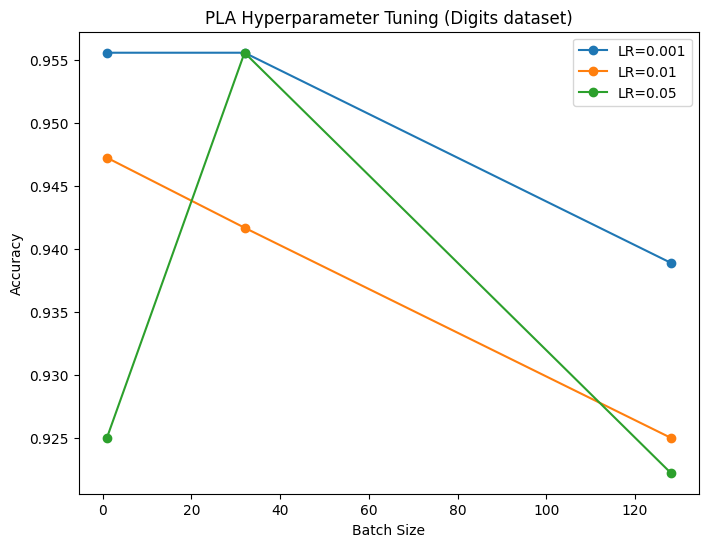

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits  # Example dataset (multiclass)

# ---------------------------
# PLA Class (Multiclass)
# ---------------------------
class PLA:
    def __init__(self, n_features, n_classes, lr=0.01, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.W = np.zeros((n_classes, n_features))  # weight matrix
        self.b = np.zeros(n_classes)               # bias vector

    def fit(self, X, y):
        """Update weights for a batch of samples"""
        for x_i, y_true in zip(X, y):
            scores = np.dot(self.W, x_i) + self.b
            y_hat = np.argmax(scores)

            if y_hat != y_true:  # misclassified
                self.W[y_true] += self.lr * x_i
                self.b[y_true] += self.lr
                self.W[y_hat]  -= self.lr * x_i
                self.b[y_hat]  -= self.lr

    def predict(self, X):
        scores = np.dot(X, self.W.T) + self.b
        return np.argmax(scores, axis=1)


# ---------------------------
# Train with hyperparameters
# ---------------------------
def train_with_hyperparams(X_train, y_train, X_test, y_test, learning_rates, batch_sizes, epochs=10):
    results = {}

    for eta in learning_rates:
        for batch_size in batch_sizes:
            pla = PLA(n_features=X_train.shape[1], n_classes=len(np.unique(y_train)), lr=eta, epochs=epochs)

            n_samples = X_train.shape[0]
            for epoch in range(epochs):
                indices = np.arange(n_samples)
                np.random.shuffle(indices)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                for i in range(0, n_samples, batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]
                    pla.fit(X_batch, y_batch)

            # Evaluate
            y_pred = pla.predict(X_test)
            acc = np.mean(y_pred == y_test)

            results[(eta, batch_size)] = acc
            print(f"LR={eta}, Batch={batch_size} → Accuracy={acc:.4f}")

    return results


# ---------------------------
# Example run on digits dataset
# ---------------------------
# Load data (8x8 digit images → 64 features, 10 classes)
data = load_digits()
X, y = data.data, data.target

# Encode labels (ensure integers 0..C-1)
le = LabelEncoder()
y = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameters
learning_rates = [0.001, 0.01, 0.05]
batch_sizes = [1, 32, 128]  # Online, mini-batch, full-ish

# Train & evaluate
results = train_with_hyperparams(X_train, y_train, X_test, y_test, learning_rates, batch_sizes, epochs=10)

# ---------------------------
# Plot results
# ---------------------------
plt.figure(figsize=(8,6))
for eta in learning_rates:
    accs = [results[(eta, b)] for b in batch_sizes]
    plt.plot(batch_sizes, accs, marker='o', label=f"LR={eta}")

plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.title("PLA Hyperparameter Tuning (Digits dataset)")
plt.legend()
plt.show()
